In [24]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid']) #dependency: SciencePlots
from fibonacci import generate_vertices
from linear_discetisation import Linear_disc_points
from commutators import test_angular_momentum_comutator, fourier_vector, calc_r, La_Lb_commutator
from lattice_actions import calc_mean_distance
from derivative import angular_momentum, new_angular_momentum
import pathlib
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool


Lattice_Path = pathlib.Path("F:\\Studium_Physik\\Bachelorarbeit\\code\\bachelor_thesis\\lattices")

In [18]:
# create Lattices

N = np.array([i for i in range(5,11)])
lin_Lattices = [Linear_disc_points(i) for i in N]
fib_Lattices = []
optim_Lattices = []
for i in N:
    fib_path = list(Lattice_Path.absolute().glob(f"**/fib_{int(2**i)}.csv"))[0]
    optim_path = list(Lattice_Path.absolute().glob(f"**/optim_{int(2**i)}.csv"))[0]
    fib_Lattices.append(np.loadtxt(fib_path))
    optim_Lattices.append(np.loadtxt(optim_path))

#define initial params
ks = np.array([[0,0,0],[0.1,0,0],[0.5,0,0],[1,0,0]])
neighbors = [1,2,3,4,5,6]
Is = [0,1]
Js = [0,1]
As = [1,2,3]
angs = [angular_momentum, new_angular_momentum]

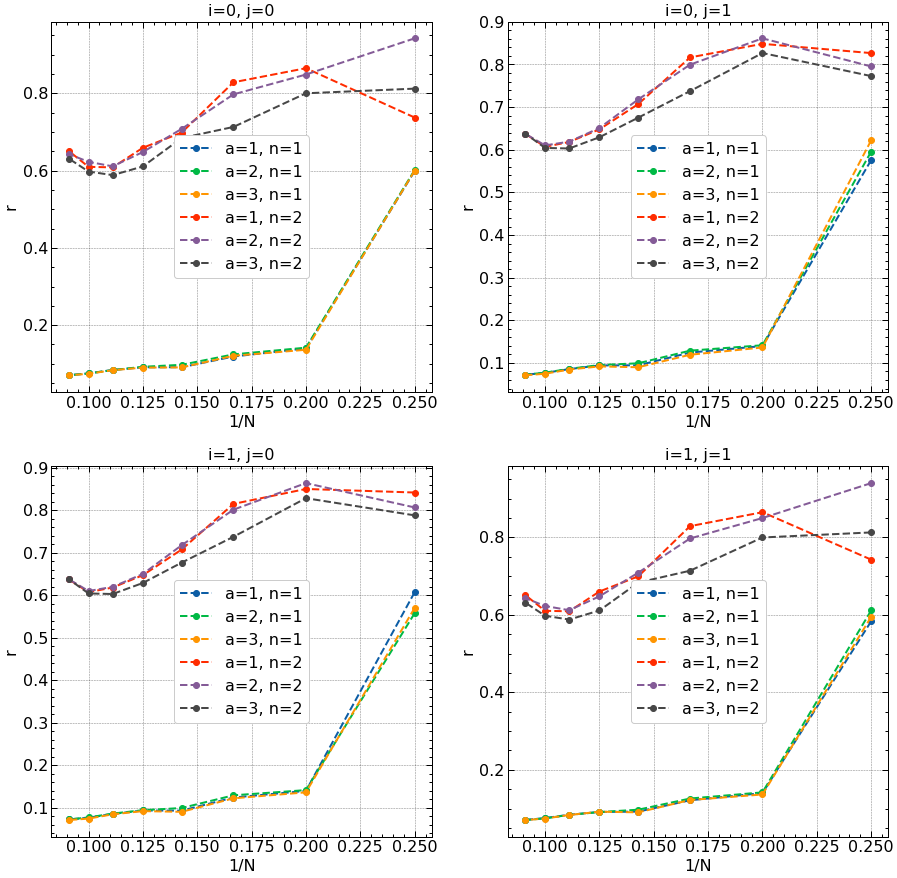

In [7]:
fig, axes = plt.subplots(2,2,figsize=(15,15))
N = np.array([i for i in range(4,12)])
#Lattices = [generate_vertices(2**i) for i in N]
Lattices = [Linear_disc_points(i) for i in N]
mean_distances= []
rs = []
n = 1
k = np.array([0.1,0,0])

for n in [1,2]:
    for a in [1,2,3]:
        for i in [0,1]:
            for j in [0,1]:
                for vertex in Lattices:
                    comm = test_angular_momentum_comutator(vertex, a, n=n, i=i,j=j)
                    vec = fourier_vector(vertex, a, k)
                    rs.append(calc_r(comm, vec=vec))
                    #mean_distances.append(calc_mean_distance(vertex))
                #plot here
                ax = axes[i][j]
                ax.set_title(f"i={i}, j={j}")
                ax.plot(1/N, rs, "o--", label=f"a={a}, n={n}")
                ax.set_ylabel("r")
                ax.set_xlabel("1/N")
                ax.legend(loc="best")
                #ax.set_yscale("log")
                #end
                mean_distances = []
                rs = []


In [19]:

mean_distances= []
lin_res = np.zeros((len(neighbors),len(Is), len(Js), len(As), ks.shape[0], len(angs), len(lin_Lattices)))
fib_res = np.zeros((len(neighbors),len(Is), len(Js), len(As), ks.shape[0], len(angs), len(fib_Lattices)))
opt_res = np.zeros((len(neighbors),len(Is), len(Js), len(As), ks.shape[0], len(angs), len(optim_Lattices)))


for i_n, n in enumerate(neighbors):
    for i in [0,1]:
        for j in [0,1]:
            for a in [1,2,3]:
                for i_ang, ang in enumerate(angs):
                    for index, (lin, fib, opt) in enumerate(zip(lin_Lattices,fib_Lattices,optim_Lattices)):
                        lin_comm = test_angular_momentum_comutator(lin, a, n=n, i=i,j=j, ang=ang)
                        fib_comm = test_angular_momentum_comutator(fib, a, n=n, i=i,j=j, ang=ang)
                        opt_comm = test_angular_momentum_comutator(opt, a, n=n, i=i,j=j, ang=ang)
                        for i_k, k in enumerate(ks):
                            vec = fourier_vector(lin, a, k)
                            lin_res[i_n, i, j, a-1, i_k, i_ang, index] = calc_r(lin_comm, vec=vec).real
                            vec = fourier_vector(fib, a, k)
                            fib_res[i_n, i, j, a-1, i_k, i_ang, index] = calc_r(fib_comm, vec=vec).real
                            vec = fourier_vector(opt, a, k)
                            opt_res[i_n, i, j, a-1, i_k, i_ang, index] = calc_r(opt_comm, vec=vec).real
                    
lin_res = np.mean(lin_res, axis=3)
fib_res = np.mean(fib_res, axis=3)
opt_res = np.mean(opt_res, axis=3)

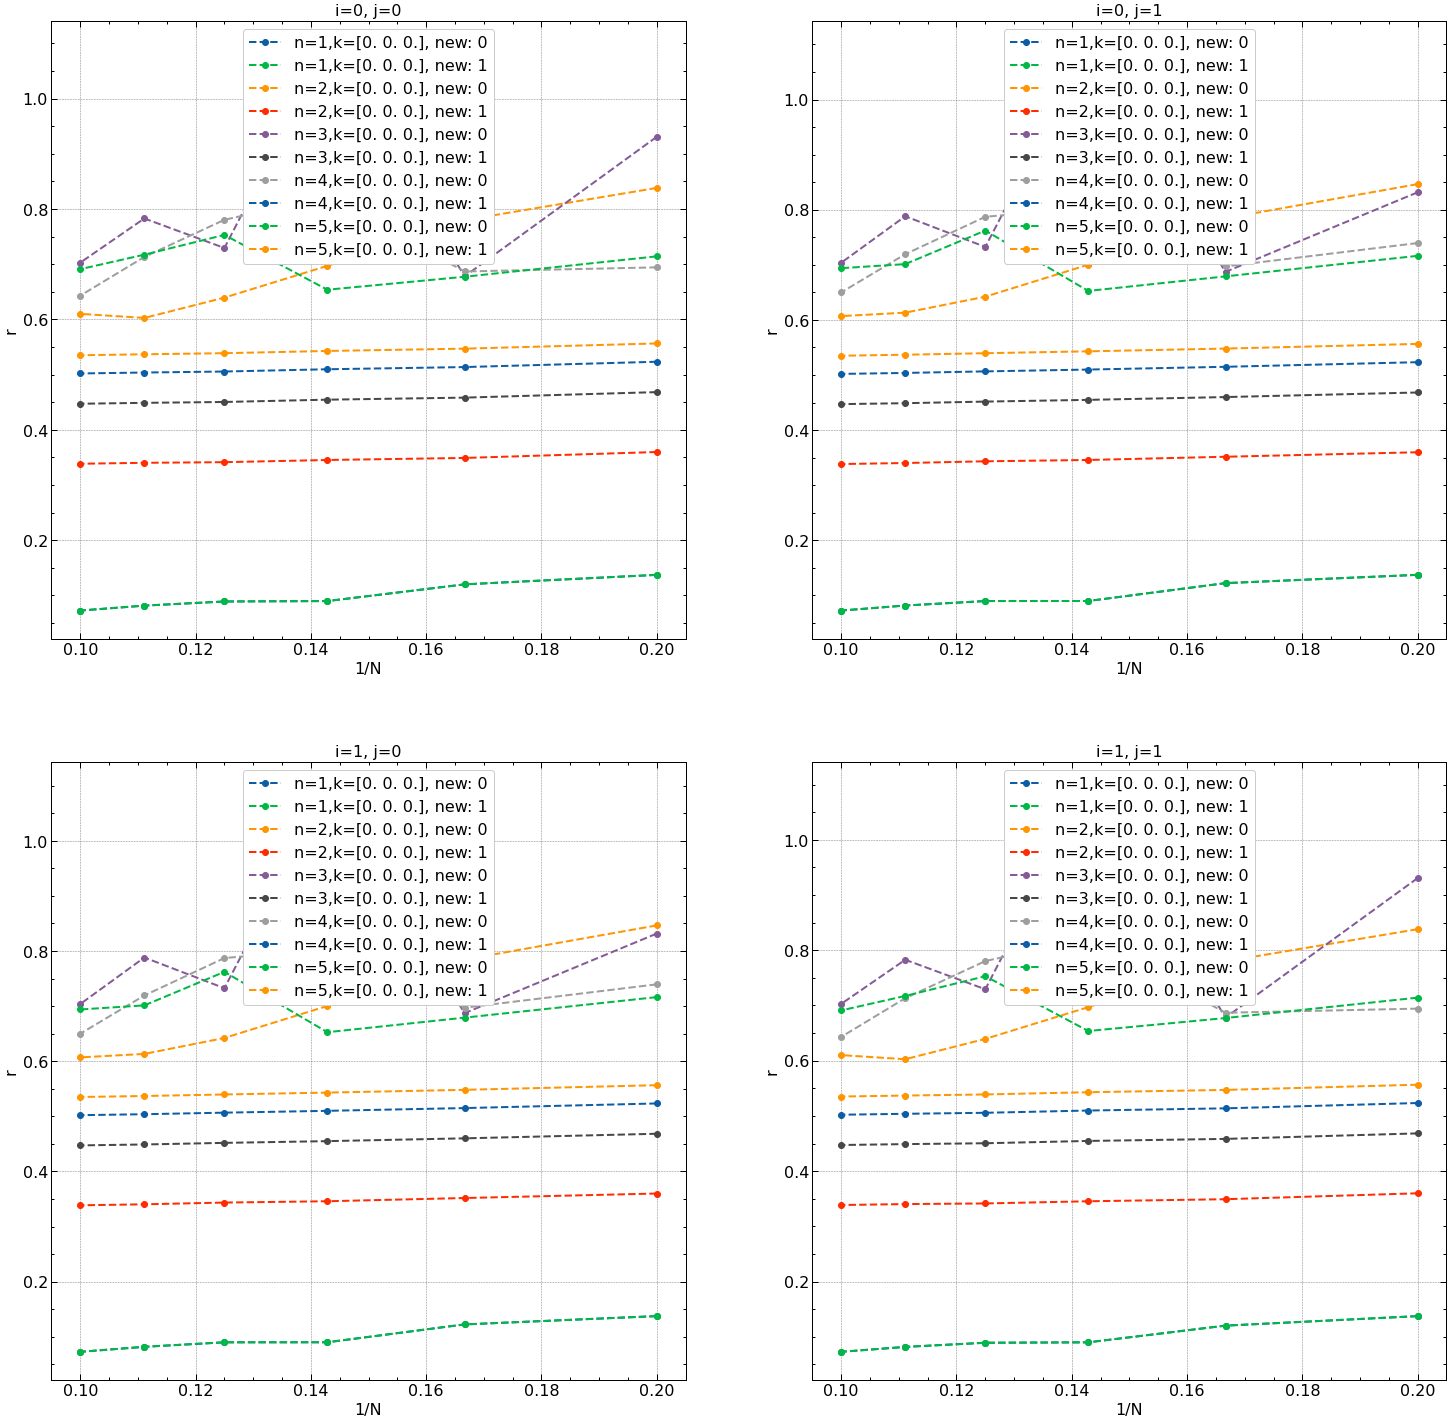

In [23]:
fig, axes = plt.subplots(2,2,figsize=(25,25))

#plotting
for i0, n in enumerate(neighbors[:5]):
    for i1, i in enumerate(Is):
        for i2, j in enumerate(Js):
            ax = axes[i1][i2]
            for i3, k in enumerate(ks[:1]):
                for i4, _ in enumerate(angs):                
                    y = lin_res[i0,i1,i2,i3,i4]
                    ax.plot(1/N, y, 'o--', label=f"n={n},k={k}, new: {i4}")
            ax.set_title(f"i={i}, j={j}")
            ax.legend(loc="best")
            ax.set_ylabel("r")
            ax.set_xlabel("1/N")

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(25,25))

#plotting
for i0, n in enumerate(neighbors[:5]):
    for i1, i in enumerate(Is):
        for i2, j in enumerate(Js):
            ax = axes[i1][i2]
            for i3, k in enumerate(ks[:1]):
                for i4, _ in enumerate(angs):                
                    y = lin_res[i0,i1,i2,i3,i4]
                    ax.plot(1/N, y, 'o--', label=f"n={n},k={k}, new: {i4}")
            ax.set_title(f"i={i}, j={j}")
            ax.legend(loc="best")
            ax.set_ylabel("r")
            ax.set_xlabel("1/N")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


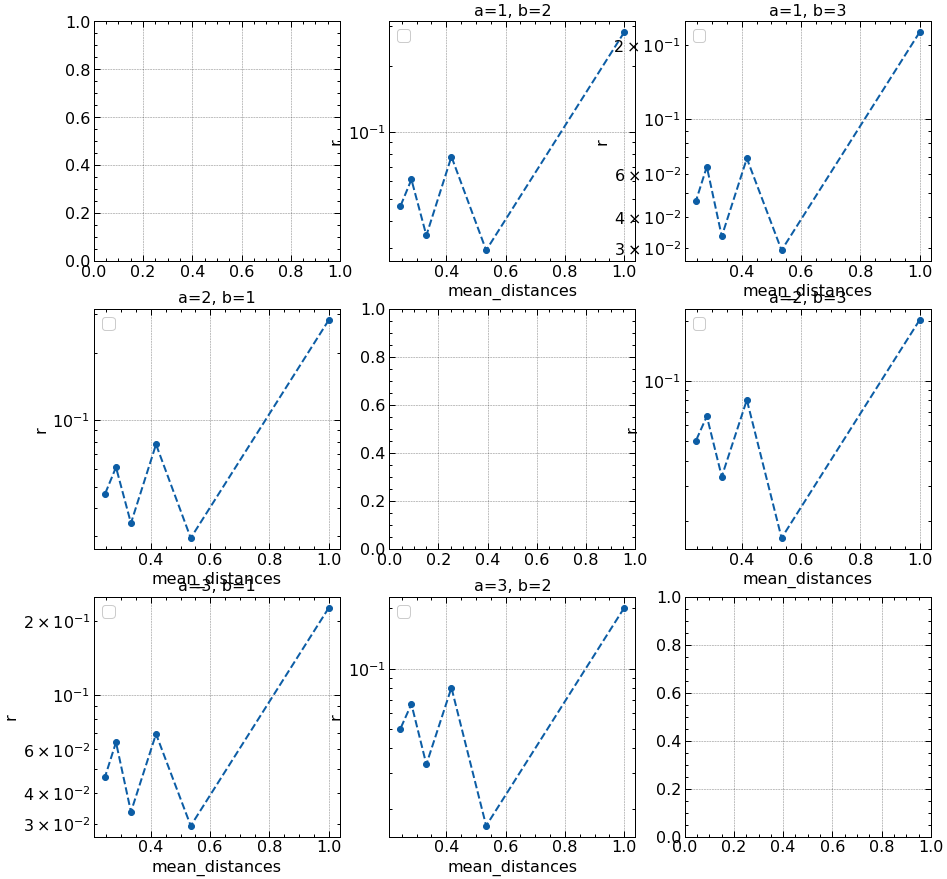

In [6]:
fig, axes = plt.subplots(3,3,figsize=(15,15))
N = np.array([i for i in range(4,10)])
#Lattices = [generate_vertices(2**i) for i in N]
Lattices = [Linear_disc_points(i) for i in N]
mean_distances= []
rs = []
k = np.array([0.1,0,0])


for a in [1,2,3]:
    for b in [1,2,3]:
        if a==b:
            continue
        for vertex in Lattices:
            comm = La_Lb_commutator(vertex, a, b, n=1)
            vec = fourier_vector(vertex, 1, k)
            rs.append(calc_r(comm, vec=vec))
            mean_distances.append(calc_mean_distance(vertex))
        #plot here
        ax = axes[a-1][b-1]
        ax.set_title(f"a={a}, b={b}")
        ax.plot(mean_distances, rs, "o--")
        ax.set_ylabel("r")
        ax.set_xlabel("mean_distances")
        #ax.legend(loc="best")
        ax.set_yscale("log")
        #end
        mean_distances = []
        rs = []

\begin{equation*}
    z = \big([L_a,U_{il}] - (t_a)_{ji} U_{il})\cdot v(k)
\end{equation*}

\begin{equation*}
    r = \frac{1}{N}\sum_i |z_i|
\end{equation*}

### Eigenvalues

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid']) #dependency: SciencePlots
from fibonacci import generate_vertices, generate_vertices_angles
from lattice_optimisation import lattice_optimizer, angles_to_cartesian
from hamiltonian import calc_eigenvals, continuum_spectrum, generate_Ldagger_L
from derivative import new_angular_momentum

num_eigenvals = 75
id_s = list(range(num_eigenvals))
eigenvals = continuum_spectrum(num_eigenvals)


neighbors = [1,2,4]
exponents = [8,10, 11,12]
fib_Lattices = [generate_vertices(2**i) for i in exponents]
optim_Lattices = [angles_to_cartesian(lattice_optimizer(generate_vertices_angles(2**i))[0]) for i in exponents]

fib_eigenvals = np.zeros((len(neighbors),len(exponents), num_eigenvals))
optim_eigenvals = np.zeros((len(neighbors),len(exponents), num_eigenvals))
print(fib_eigenvals.shape)

for index, (exponent, fib, optim) in enumerate(zip(exponents,fib_Lattices, optim_Lattices)):
    for i,n in enumerate(neighbors):
        fib_L = generate_Ldagger_L(fib,n=n,ang=new_angular_momentum)
        fib_eigenvals[i,index,:] = calc_eigenvals(fib_L, k=num_eigenvals)
        optim_L = generate_Ldagger_L(optim,n=n, ang=new_angular_momentum)
        optim_eigenvals[i,index,:] = calc_eigenvals(optim_L, k=num_eigenvals)

(3, 4, 75)


<ipython-input-4-124f31722273>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  fib_eigenvals[i,index,:] = calc_eigenvals(fib_L, k=num_eigenvals)
<ipython-input-4-124f31722273>:28: ComplexWarning: Casting complex values to real discards the imaginary part
  optim_eigenvals[i,index,:] = calc_eigenvals(optim_L, k=num_eigenvals)


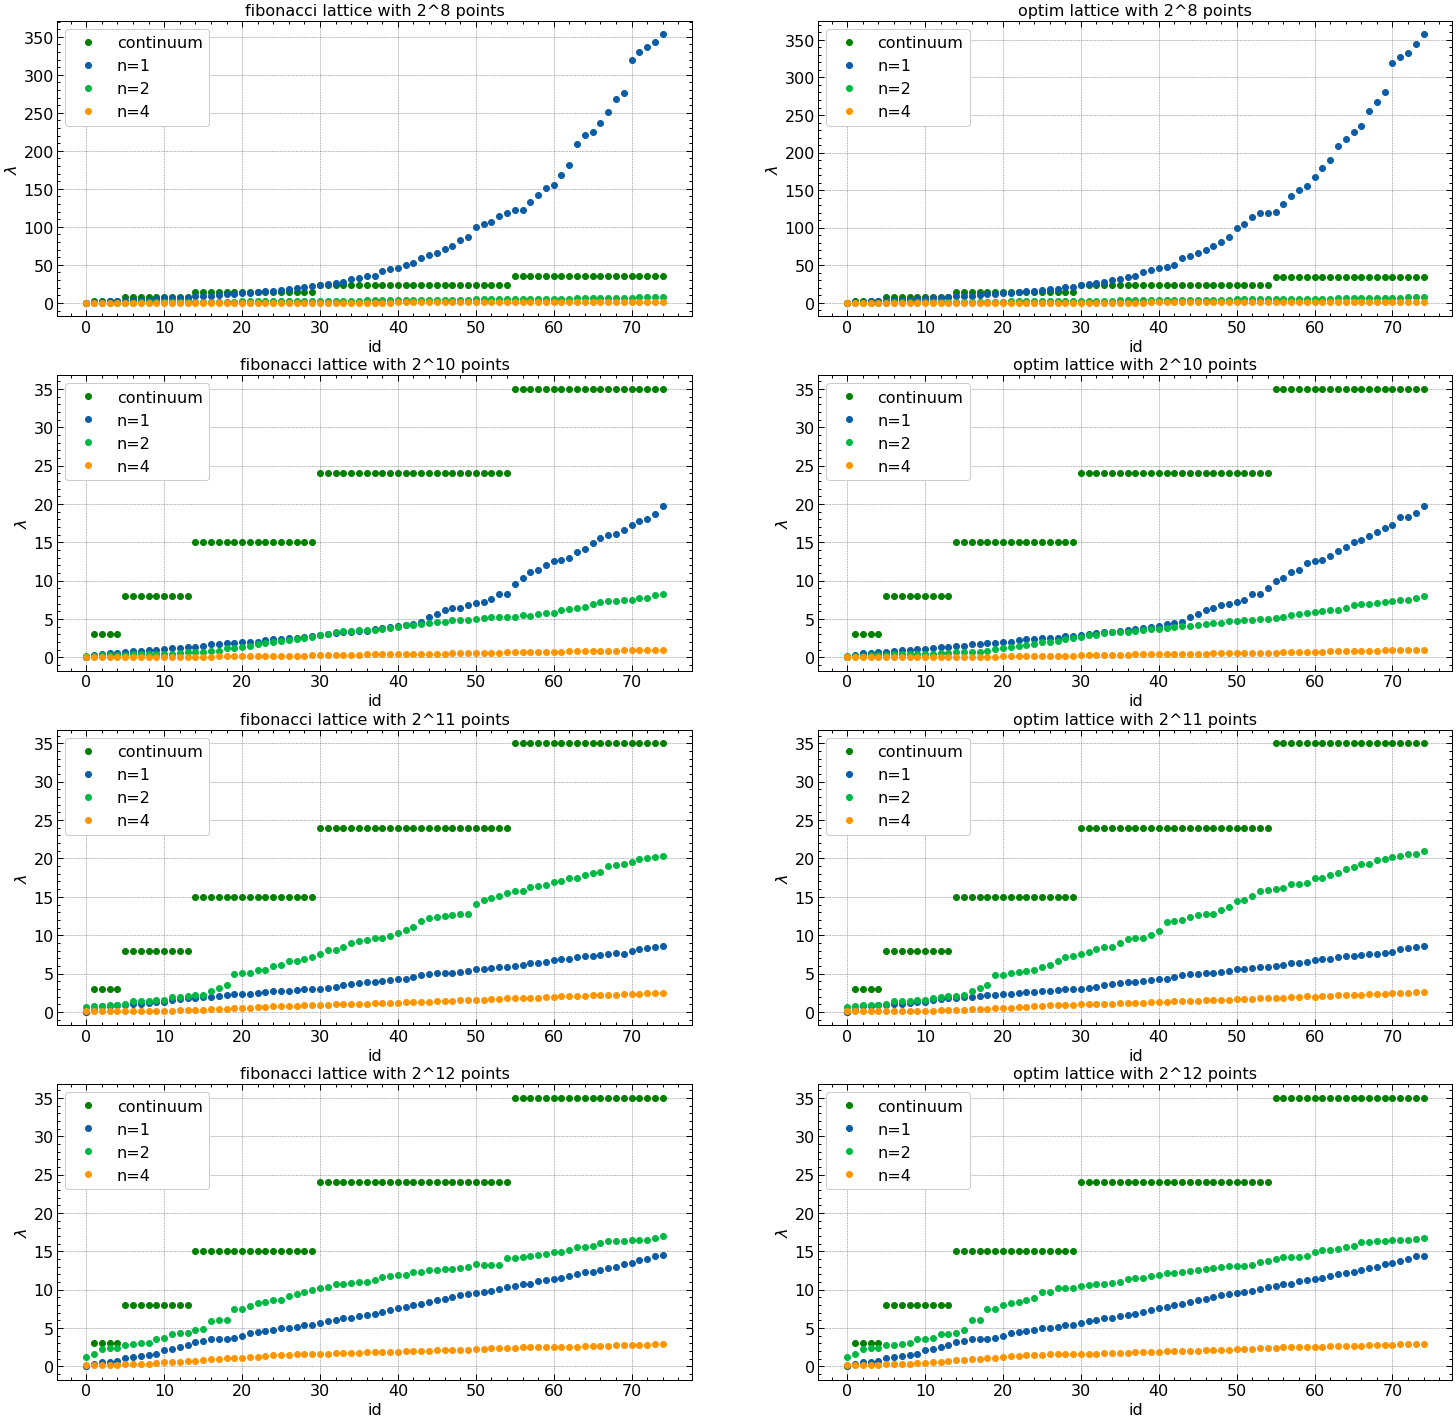

In [5]:
fig, axes = plt.subplots(len(exponents),2,figsize=(25,25))

for index, exponent in enumerate(exponents):
    ax = axes[index,:]
    ax[0].plot(id_s, eigenvals, "o", label = "continuum", color="green")
    ax[1].plot(id_s, eigenvals, "o", label = "continuum", color="green")
    for i,n in enumerate(neighbors):
        ax[0].plot(id_s, fib_eigenvals[i,index,:], "o", label=rf"n={n}")
        ax[1].plot(id_s, optim_eigenvals[i,index,:], "o", label=rf"n={n}")
    ax[0].set_title(rf"fibonacci lattice with 2^{exponent} points")
    ax[1].set_title(rf"optim lattice with 2^{exponent} points")
    ax[0].legend(loc="best")
    ax[1].legend(loc="best")
    ax[0].set_xlabel("id")
    ax[1].set_xlabel("id")
    ax[0].set_ylabel(r"$\lambda$")
    ax[1].set_ylabel(r"$\lambda$")


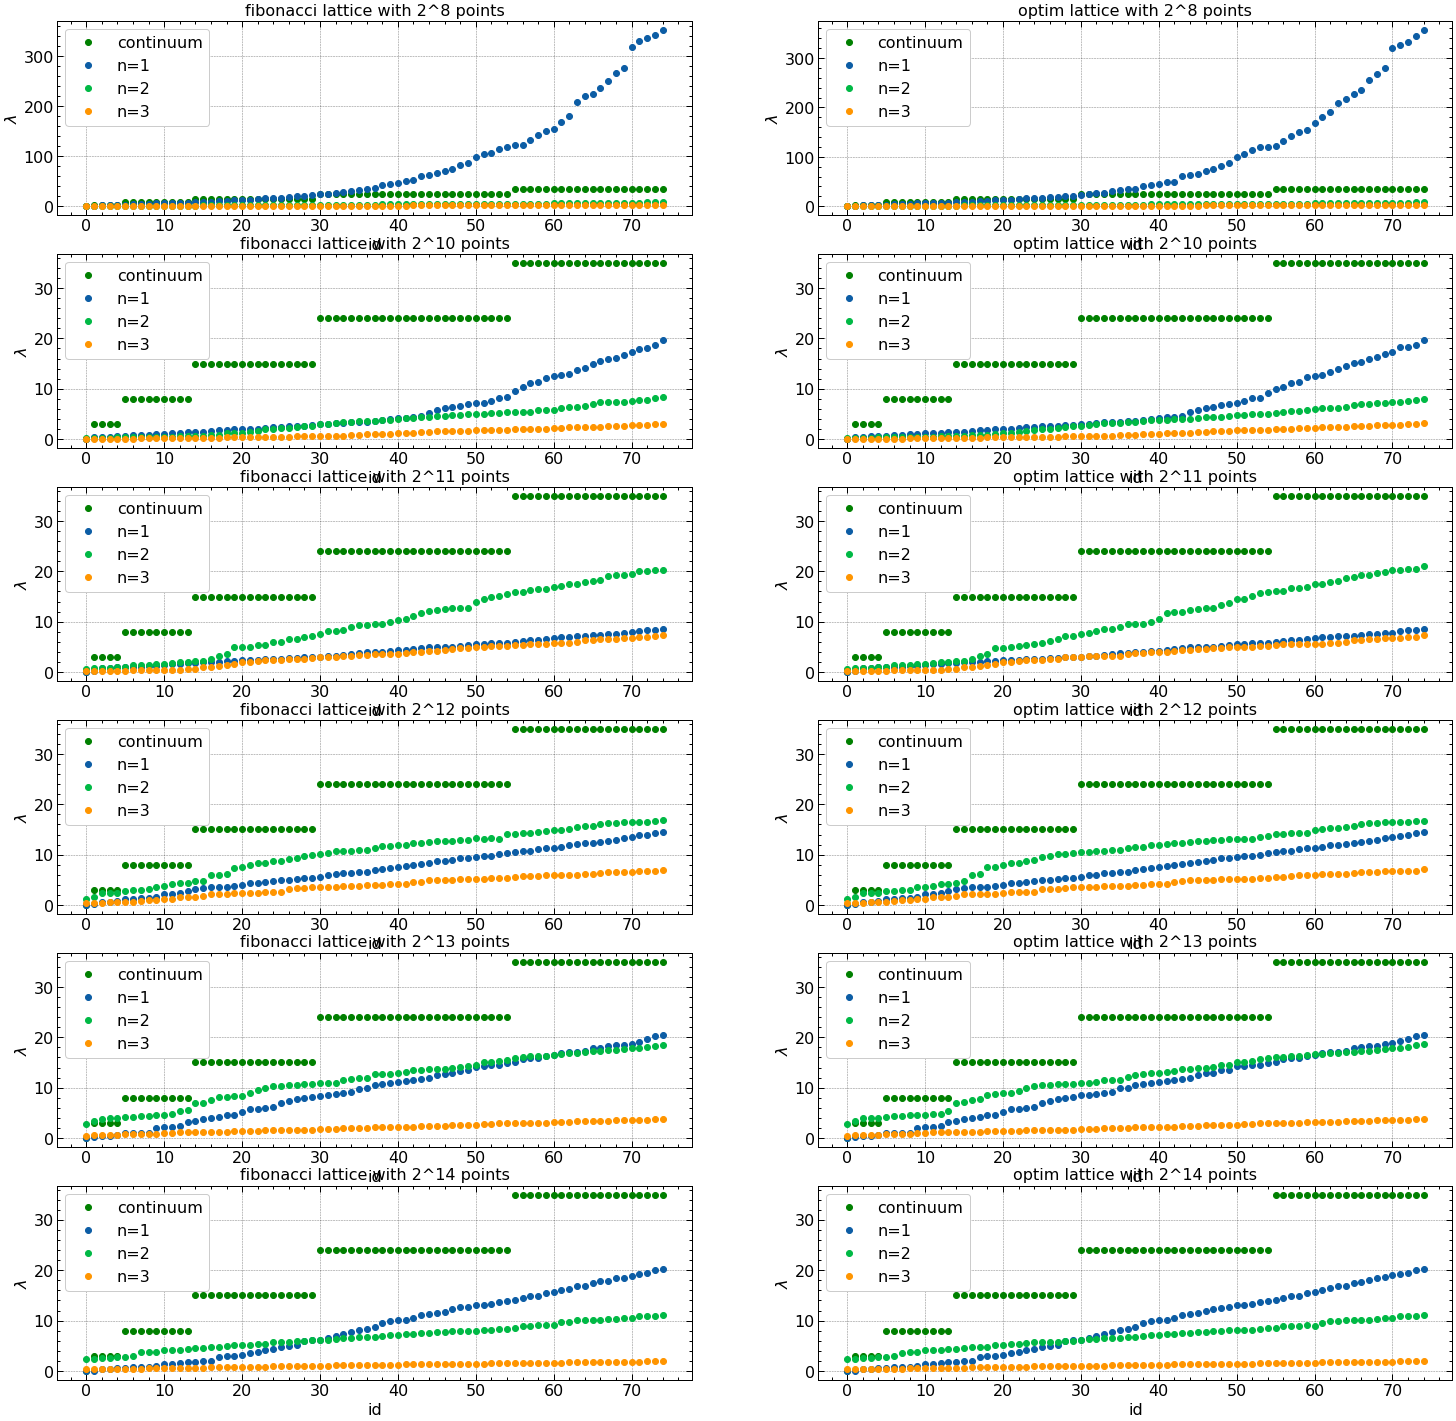

In [3]:
fig, axes = plt.subplots(len(exponents),2,figsize=(25,25))

for index, exponent in enumerate(exponents):
    ax = axes[index,:]
    ax[0].plot(id_s, eigenvals, "o", label = "continuum", color="green")
    ax[1].plot(id_s, eigenvals, "o", label = "continuum", color="green")
    for i,n in enumerate(neighbors):
        ax[0].plot(id_s, fib_eigenvals[i,index,:], "o", label=rf"n={n}")
        ax[1].plot(id_s, optim_eigenvals[i,index,:], "o", label=rf"n={n}")
    ax[0].set_title(rf"fibonacci lattice with 2^{exponent} points")
    ax[1].set_title(rf"optim lattice with 2^{exponent} points")
    ax[0].legend(loc="best")
    ax[1].legend(loc="best")
    ax[0].set_xlabel("id")
    ax[1].set_xlabel("id")
    ax[0].set_ylabel(r"$\lambda$")
    ax[1].set_ylabel(r"$\lambda$")




##### Idea:
use and maximise
\begin{equation*}
    y = \frac{1}{N}\sum_{i \ne j} d(X_i, X_j) + \lambda(R-1)
\end{equation*}
by using spherical coordinates and restricting the sum to the nearest n neighbors of each Lattice point $X_i$ now consisting of the three angles $X_i = (\psi_i, \theta_i, \Phi_i)$
\begin{equation*}
    y = \frac{1}{N}\sum_{i \ne j} NO
\end{equation*}
(this is the mean distance of the nearest n neighbors of each Lattice point; $N = n\cdot dim(X_i)$)

##### Implementation:
then calculating the gradient $\nabla y$ and iteratively adding it to the current Lattice coordinates as
\begin{equation*}
    X_{new} = X_{old} + d\nabla y
\end{equation*}

using the difference $|y_{new} - y_{old}| < \epsilon$ as a cutoff as well as the factor $d$ (I don't know why using this as $d$ works as well as it does)

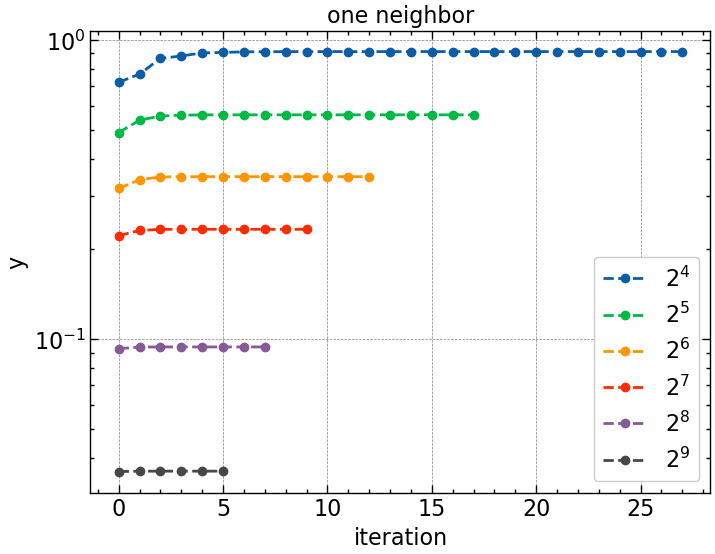

In [ ]:
from lattice_optimisation import lattice_optimizer
from fibonacci import generate_vertices_angles

N = np.array([i for i in range(4,10)])
eps = 1e-10
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr = lattice_optimizer(angles, eps=eps, neighbors=1)

    plt.plot(arr,"o--", label=rf"$2^{exp}$")


plt.xlabel("iteration")
plt.ylabel("y")
plt.legend(loc="best")
plt.title("one neighbor")
plt.yscale("log")
plt.show()

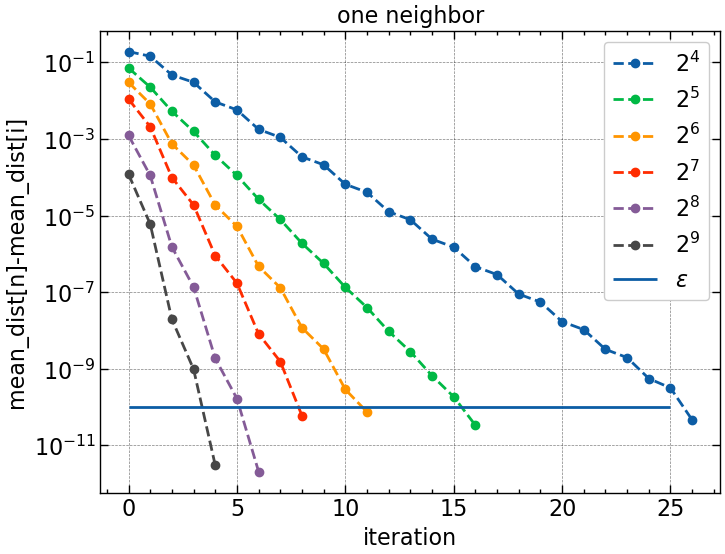

In [ ]:
N = np.array([i for i in range(4,10)])
eps = 1e-10
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr = lattice_optimizer(angles, eps=eps, neighbors=1)
    arr = (mean-arr)[:-1]
    plt.plot(arr,"o--", label=rf"$2^{exp}$")

plt.hlines(eps, 0,25, label=rf"$\epsilon$")
plt.xlabel("iteration")
plt.ylabel("mean_dist[n]-mean_dist[i]")
plt.legend(loc="best")
plt.title("one neighbor")
plt.yscale("log")
plt.show()

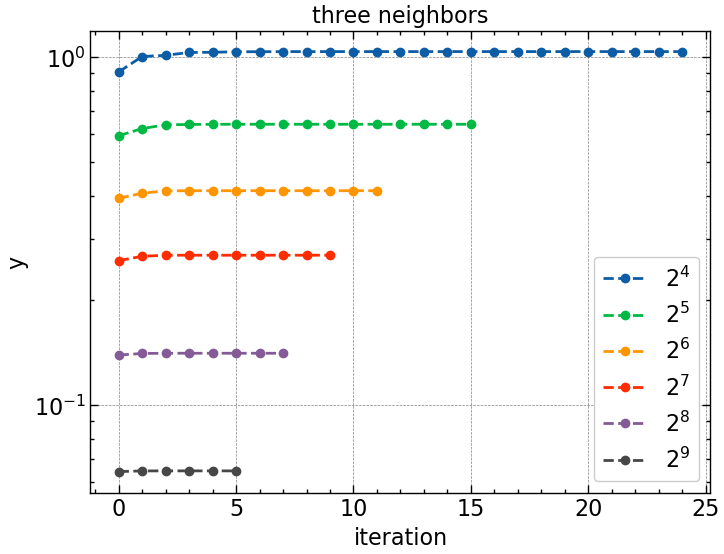

In [ ]:
N = np.array([i for i in range(4,10)])
eps = 1e-10
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr = lattice_optimizer(angles, eps=eps, neighbors=3)
    plt.plot(arr,"o--", label=rf"$2^{exp}$")

plt.xlabel("iteration")
plt.ylabel("y")
plt.legend(loc="best")
plt.title("three neighbors")
plt.yscale("log")
plt.show()

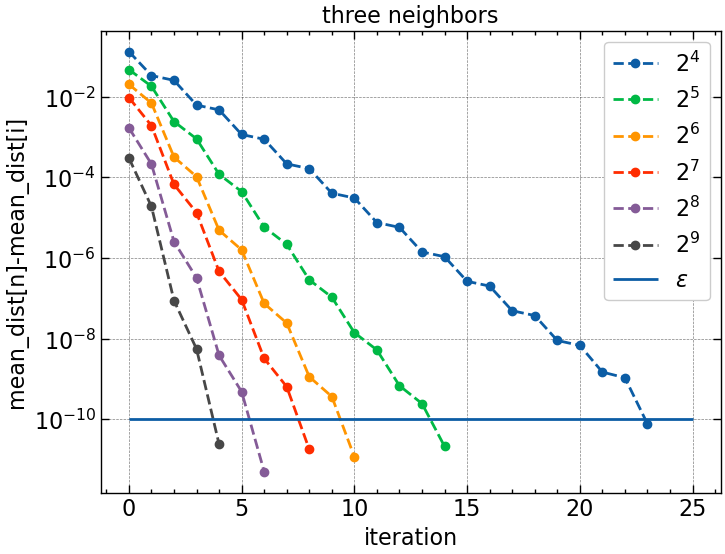

In [ ]:
N = np.array([i for i in range(4,10)])
eps = 1e-10
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr = lattice_optimizer(angles, eps=eps, neighbors=3)
    arr = (mean-arr)[:-1]
    plt.plot(arr,"o--", label=rf"$2^{exp}$")

plt.hlines(eps, 0,25, label=rf"$\epsilon$")
plt.xlabel("iteration")
plt.ylabel("mean_dist[n]-mean_dist[i]")
plt.legend(loc="best")
plt.title("three neighbors")
plt.yscale("log")
plt.show()

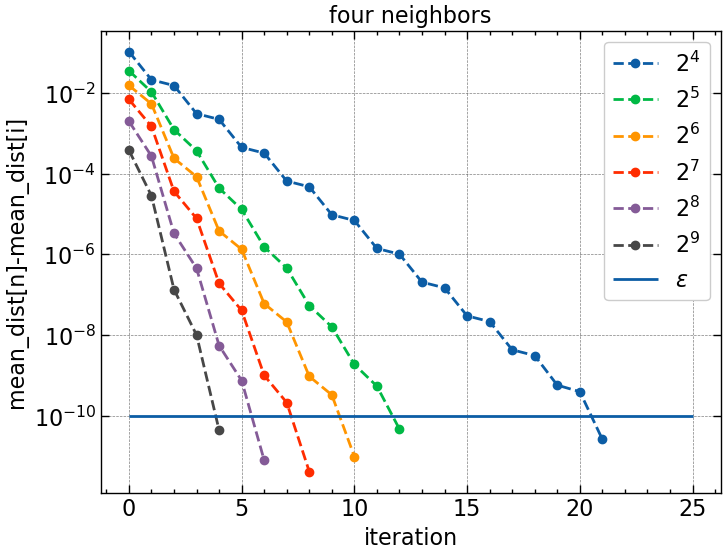

In [ ]:
N = np.array([i for i in range(4,10)])
eps = 1e-10
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr = lattice_optimizer(angles, eps=eps, neighbors=4)
    arr = (mean-arr)[:-1]
    plt.plot(arr,"o--", label=rf"$2^{exp}$")

plt.hlines(eps, 0,25, label=rf"$\epsilon$")
plt.xlabel("iteration")
plt.ylabel("mean_dist[n]-mean_dist[i]")
plt.legend(loc="best")
plt.title("four neighbors")
plt.yscale("log")
plt.show()

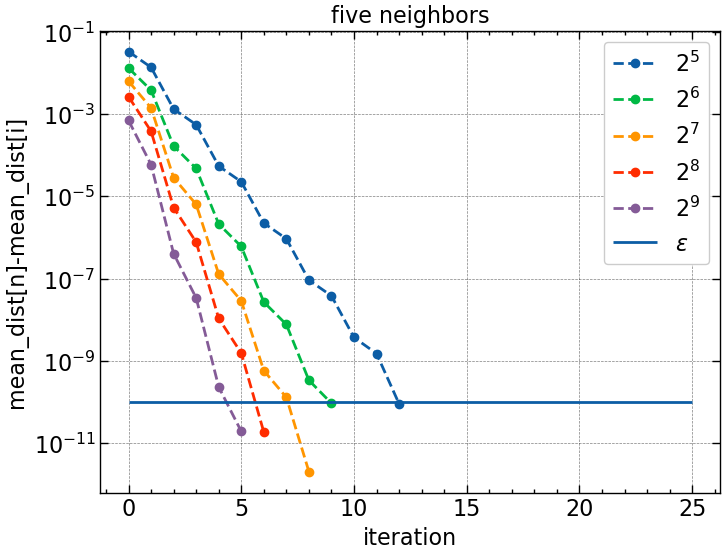

In [ ]:
N = np.array([i for i in range(5,10)])
eps = 1e-10
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr = lattice_optimizer(angles, eps=eps, neighbors=5)
    arr = (mean-arr)[:-1]
    plt.plot(arr,"o--", label=rf"$2^{exp}$")

plt.hlines(eps, 0,25, label=rf"$\epsilon$")
plt.xlabel("iteration")
plt.ylabel("mean_dist[n]-mean_dist[i]")
plt.legend(loc="best")
plt.title("five neighbors")
plt.yscale("log")
plt.show()